In [1]:
from itertools import product
import tqdm
import time
import editdistance 
import matplotlib.pyplot as plt
import plotly.express as px
import random

import pandas as pd
import numpy as np
import numba as nb
from numba import njit, jit, prange, cuda, objmode
from numba.typed import List
from numba.experimental import jitclass
import plotly.graph_objects as go
import random
from collections import defaultdict
from tqdm import tqdm
np.random.seed(0)
random.seed(0)

# Definitions 

In [2]:
@njit(fastmath=True)
def l2_dist(a, b): 
    d = a-b
    return np.sum(d*d);

@njit(fastmath=True)
def hamming_distance(a, b):
    return np.sum(a != b);

# only works for k<=32, would overflow otherwise 
@njit(fastmath=True)
def extract_kmers(seq,k):
    kmer = 0
    kmers = np.zeros(len(seq)-k+1,dtype=np.int64)
    for i,c in enumerate(seq):
        kmer = kmer * 4 + c
        kmer = kmer % (4**k)
        if i>=k:
            kmers[i-k] = kmer
    return kmers

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('signs', nb.float32[:, :])])
class TS():
    def __init__(self, t, D, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T

    def sketch_one(self, seq: np.ndarray) -> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])

        sketch = sketch.flatten()
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
class TSS():
    def __init__(self, seq_len, t, W, S, D, A, normalize = True, sketch_class=TS):
        # reduce sketch dim to ensure that the flattened sketch size is D 
        D2 = int(D/int((seq_len-W)/S)+1)   
        self.sketcher = sketch_class(t=t,D=D2,A=A,normalize=normalize)
        self.t = t
        self.W = W
        self.S = S
        self.D2 = D2
        self.D = D
    
    def sketch_one(self, seq: nb.int32[:]) -> nb.float32[:,:]:
        L = int(np.ceil((len(seq)-self.W+1)/self.S))
        sketch = np.zeros((self.D2,L), dtype=np.float32)
        for si,i in enumerate(np.arange(0,len(seq)-self.W+1,self.S)):
            sketch[:,si] = self.sketcher.sketch_one(seq[i:i+self.W])
        
        return sketch
    
    def sketch(self, seqs):
        all_seqs = List()
        starts = np.arange(0,len(seqs[0])-self.W+1,self.S)
        n, m = len(seqs),len(starts)
        for seq in seqs:
            for i in starts:
                all_seqs.append(seq[i:i+self.W])
        all_sketches = self.sketcher.sketch(all_seqs)
        sketches = List()
        for i in range(n):
            sk = np.array([x for sk in all_sketches[i*m:(i+1) * m] for x in sk])
            sketches.append(sk)
        return sketches
    
    def dist(self, s1, s2):
        return l2_dist(s1,s2)

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('D2', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('G', nb.float64[:, :]),
    ('H', nb.float64[:]),
    ('signs', nb.float32[:, :])])
class DTS():
    def __init__(self, t, D, D2, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.D2 = D2
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        # Gaussian matrix for discretization
        self.G = np.empty((self.D , self.D2), dtype=np.float64)
        for i in range(self.D):
            for j in range(self.D2):
                self.G[i,j] = random.normalvariate(0,1)
                
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T
    

    def discretize(self, x: nb.float64[:]) -> np.int64:
        x = x.dot(self.G)
#         H = np.tensordot(self.G, x, axes=(1, 0))
        H = (x>0)
        H = H.reshape(-1,8)
        S = np.zeros((H.shape[0]),np.int64)
        for i in range(H.shape[0]):
            arr = H[i]
            S[i] = (arr[0]<<8) + (arr[0]<<7)|(arr[1]<<6)|(arr[2]<<5)|(arr[3]<<4)|(arr[4]<<3)|(arr[5]<<2)|(arr[6]<<1)|arr[7]
        sh = 0
        for s in S:
            sh = hash(sh) ^ hash(str(s))
        return sh

    def sketch_one(self, seq: np.ndarray)-> np.int64: #-> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])
        sketch = sketch.flatten()
        sketch = self.discretize(sketch)
        return sketch

    def sketch(self, seqs):
        sketches = np.zeros((len(seqs)),np.int64)
        for i in range(len(seqs)):
            sketches[i] = self.sketch_one(seqs[i])
        return sketches
        # return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    

def mutate(seq, alphabet, rate):
    new_seq = []
    n = len(seq)
    i = 0
    alg = []
    while i < n:
        chance = np.random.uniform()
        if chance > rate:
            # do nothing
            alg.append(i)
            new_seq.append(seq[i])
            i += 1
        else:
            # choose at random an operation between substitution, insertion, deletion
            op = np.random.choice([0,1,2])            
            if op == 0:
                # substitution
                c = np.random.choice(list(set(alphabet) - set([seq[i]])))
                new_seq.append(c)
                alg.append(i)
                i += 1
            elif op == 1:
                # insertion
                c = np.random.choice(alphabet)
                alg.append(i)
                new_seq.append(c)
            elif op == 2:
                # deletion
                i += 1
    D = len(seq) - len(new_seq)
    new_seq = new_seq + [np.random.choice(alphabet) for _ in range(D)]
    alg = alg + [i for _ in range(D)]
    return ''.join(new_seq),alg
    
def convert(seq, alphabet):
    inv_map = {alphabet[i]:i for i in range(len(alphabet))}
    new_seq = []
    for c in seq:
        new_seq.append(inv_map[c])
    return np.asarray(new_seq, dtype=np.uint8)

def generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet):
    paths = []
    for i in range(num_paths):
        # pick random index
        start = np.random.choice(len(seq) - path_len)
        path = seq[start:start+path_len]
        seq2,align =  mutate(path, alphabet, mutation_rate)
        nodes = [start+i for i in align]
        paths.append((path,seq2, nodes))
    return paths

def build_lookup(sketches, stride):
    lut = defaultdict(list)
    for i, s in enumerate(sketches):
        lut[s].append(i*stride)
    return lut

def dict_configs(d):
    for k,v in d.items():
        if not isinstance(v,list):
            d[k] = [v]
    for vcomb in product(*d.values()):
        yield dict(zip(d.keys(), vcomb))

# Experiment 

100%|██████████| 100/100 [00:01<00:00, 54.18it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 32, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0006119875131369915, 'R': 1.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([99,  1,  0,  0,  0,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:00<00:00, 349.64it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 32, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0031002750247377986, 'R': 0.78, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([54,  8, 13,  3,  1,  0,  3,  2,  1, 15])}


100%|██████████| 100/100 [00:00<00:00, 312.47it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 32, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0017736715619212954, 'R': 0.81, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([55,  8, 16,  2,  7,  1,  1,  1,  0,  9])}


100%|██████████| 100/100 [00:00<00:00, 233.94it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 32, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.0013182323822051492, 'R': 0.88, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([65,  4, 15,  4,  3,  0,  2,  0,  0,  7])}


100%|██████████| 100/100 [00:00<00:00, 141.35it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 64, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0011738695028999221, 'R': 0.99, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([88,  4,  7,  0,  1,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:00<00:00, 401.35it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 64, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0013735816303771526, 'R': 0.5, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([25, 13, 10,  2,  9,  3,  3,  2,  2, 31])}


100%|██████████| 100/100 [00:00<00:00, 468.95it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 64, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0022558894334439037, 'R': 0.13, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 3,  2,  8,  0,  0,  3,  2,  1,  2, 79])}


100%|██████████| 100/100 [00:00<00:00, 424.82it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 64, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.002039401549485087, 'R': 0.23, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([11,  2,  7,  3,  3,  2,  3,  2,  1, 66])}


100%|██████████| 100/100 [00:00<00:00, 467.56it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 128, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  0,  0,  0,  0,  2,  0,  0, 98])}


100%|██████████| 100/100 [00:00<00:00, 476.76it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 128, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  0,  0,  0,  0,  1,  0,  0, 99])}


100%|██████████| 100/100 [00:00<00:00, 452.08it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 128, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.003918128654970761, 'R': 0.04, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  2,  1,  0,  1,  0,  1,  0,  2, 92])}


100%|██████████| 100/100 [00:00<00:00, 414.11it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 10, 'm2': 128, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.021577380952380952, 'R': 0.04, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  3,  1,  1,  1,  0,  0,  0, 94])}


100%|██████████| 100/100 [00:00<00:00, 202.02it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 32, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0016530110042264603, 'R': 0.98, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([76,  4, 16,  2,  1,  0,  0,  0,  0,  1])}


100%|██████████| 100/100 [00:01<00:00, 52.77it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 32, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0005946818968262034, 'R': 0.98, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([98,  0,  0,  0,  2,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:00<00:00, 345.53it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 32, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0033534921524324217, 'R': 0.64, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([45,  3, 14,  2,  8,  0,  2,  1,  1, 24])}


100%|██████████| 100/100 [00:00<00:00, 264.87it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 32, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.00178481120379097, 'R': 0.77, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([44,  9, 19,  5,  4,  3,  0,  0,  3, 13])}


100%|██████████| 100/100 [00:00<00:00, 416.61it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 64, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0044919420330017616, 'R': 0.42, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([20,  5, 13,  4,  2,  1,  4,  2,  1, 48])}


100%|██████████| 100/100 [00:00<00:00, 391.31it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 64, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.00444545900149936, 'R': 0.32, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([11,  2, 14,  5,  0,  3,  3,  4,  0, 58])}


100%|██████████| 100/100 [00:00<00:00, 374.95it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 64, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.009683758395098602, 'R': 0.11, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 6,  0,  4,  1,  2,  0,  0,  2,  2, 83])}


100%|██████████| 100/100 [00:00<00:00, 335.32it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 64, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.012512195710562604, 'R': 0.14, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 9,  2,  3,  0,  0,  0,  1,  1,  0, 84])}


100%|██████████| 100/100 [00:00<00:00, 406.40it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 128, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.01616588193719046, 'R': 0.07, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 2,  1,  3,  1,  4,  3,  2,  0,  1, 83])}


100%|██████████| 100/100 [00:00<00:00, 323.11it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 128, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0020998201070170103, 'R': 0.44, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([24,  4, 15,  1, 12,  1,  3,  2,  1, 37])}


100%|██████████| 100/100 [00:00<00:00, 339.38it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 128, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.09090909090909091, 'R': 0.01, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  1,  0,  0,  0,  0,  0,  0, 99])}


100%|██████████| 100/100 [00:00<00:00, 314.17it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 20, 'm2': 128, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  0,  0,  1,  0,  0,  0,  0, 99])}


100%|██████████| 100/100 [00:00<00:00, 172.15it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 32, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0016984025716132506, 'R': 0.96, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([83,  5,  8,  0,  0,  0,  2,  0,  0,  2])}


100%|██████████| 100/100 [00:00<00:00, 294.60it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 32, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.003495261676806928, 'R': 0.56, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([39,  4, 11,  2,  7,  1,  2,  4,  1, 29])}


100%|██████████| 100/100 [00:00<00:00, 285.53it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 32, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0035949968207974847, 'R': 0.64, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([41,  5, 13,  5,  8,  0,  8,  1,  0, 19])}


100%|██████████| 100/100 [00:00<00:00, 276.96it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 32, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.010752099560118314, 'R': 0.23, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([15,  4,  2,  2,  5,  0,  3,  3,  1, 65])}


100%|██████████| 100/100 [00:00<00:00, 327.52it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 64, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.003989812932875801, 'R': 0.67, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([41,  6, 19,  1,  2,  7,  2,  1,  1, 20])}


100%|██████████| 100/100 [00:00<00:00, 339.23it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 64, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.014883926989190149, 'R': 0.06, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 2,  1,  1,  2,  3,  3,  0,  0,  0, 88])}


100%|██████████| 100/100 [00:00<00:00, 286.11it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 64, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.007270623751559087, 'R': 0.27, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([11,  2, 12,  2,  5,  0,  3,  1,  2, 62])}


100%|██████████| 100/100 [00:00<00:00, 277.88it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 64, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.0770440251572327, 'R': 0.06, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 3,  2,  1,  0,  0,  0,  1,  0,  1, 92])}


100%|██████████| 100/100 [00:00<00:00, 346.99it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 128, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.024776785714285713, 'R': 0.07, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 5,  0,  2,  0,  3,  0,  0,  0,  0, 90])}


100%|██████████| 100/100 [00:00<00:00, 295.33it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 128, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:00<00:00, 269.32it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 128, 'tuplen': 5, 'w': 50, 's': 3, 'P': 1.0, 'R': 0.01, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 0,  0,  1,  0,  0,  0,  0,  0,  0, 99])}


100%|██████████| 100/100 [00:00<00:00, 241.59it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 30, 'm2': 128, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:01<00:00, 68.62it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 32, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0008398985519945948, 'R': 1.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([97,  2,  1,  0,  0,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:00<00:00, 242.30it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 32, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.006417481254199554, 'R': 0.71, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([49, 10, 12,  0,  2,  2,  3,  0,  0, 22])}


100%|██████████| 100/100 [00:00<00:00, 225.80it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 32, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.005697154369389496, 'R': 0.44, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([29,  4, 11,  0,  7,  2,  1,  2,  0, 44])}


100%|██████████| 100/100 [00:00<00:00, 203.97it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 32, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.00964505764260698, 'R': 0.38, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([18,  5, 15,  0,  1,  2,  2,  0,  2, 55])}


100%|██████████| 100/100 [00:00<00:00, 279.50it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 64, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.005983307164727232, 'R': 0.37, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([20,  3, 13,  1, 11,  4,  3,  1,  1, 43])}


100%|██████████| 100/100 [00:00<00:00, 247.30it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 64, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.009797453792747572, 'R': 0.29, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([17,  2,  8,  2,  3,  1,  1,  2,  1, 63])}


100%|██████████| 100/100 [00:00<00:00, 228.81it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 64, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.006929011267520063, 'R': 0.15, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 8,  2,  4,  1,  4,  0,  2,  2,  1, 76])}


100%|██████████| 100/100 [00:00<00:00, 205.09it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 64, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.01075268817204301, 'R': 0.01, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  0,  0,  0,  1,  0,  0,  0,  1, 97])}


100%|██████████| 100/100 [00:00<00:00, 263.63it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 128, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.019230769230769232, 'R': 0.01, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  0,  0,  0,  1,  0,  1,  0,  0, 97])}


100%|██████████| 100/100 [00:00<00:00, 226.01it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 128, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.0, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:00<00:00, 201.56it/s]
/home/amir/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/amir/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 128, 'tuplen': 5, 'w': 50, 's': 3, 'P': nan, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:00<00:00, 190.07it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 50, 'm2': 128, 'tuplen': 6, 'w': 50, 's': 3, 'P': nan, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:01<00:00, 72.47it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 32, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.0010224758856428346, 'R': 1.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([96,  2,  1,  1,  0,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:02<00:00, 33.35it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 32, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.00048766282110801695, 'R': 1.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([99,  1,  0,  0,  0,  0,  0,  0,  0,  0])}


100%|██████████| 100/100 [00:00<00:00, 121.79it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 32, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0018206653409433948, 'R': 0.85, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([69,  7,  9,  0,  5,  1,  3,  1,  1,  4])}


100%|██████████| 100/100 [00:00<00:00, 151.55it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 32, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.007090046720137519, 'R': 0.49, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([26,  6, 13,  4,  9,  0,  5,  1,  1, 35])}


100%|██████████| 100/100 [00:00<00:00, 210.25it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 64, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.005577239441476978, 'R': 0.58, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([39,  9,  6,  4,  7,  1,  3,  1,  0, 30])}


100%|██████████| 100/100 [00:00<00:00, 186.86it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 64, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.006213500114307083, 'R': 0.35, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([15,  5, 11,  4,  6,  4,  4,  0,  1, 50])}


100%|██████████| 100/100 [00:00<00:00, 167.03it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 64, 'tuplen': 5, 'w': 50, 's': 3, 'P': 0.0625, 'R': 0.03, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 2,  0,  1,  0,  1,  0,  1,  1,  1, 93])}


100%|██████████| 100/100 [00:00<00:00, 147.56it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 64, 'tuplen': 6, 'w': 50, 's': 3, 'P': 0.02857142857142857, 'R': 0.01, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  0,  0,  0,  0,  1,  0,  0,  0, 98])}


100%|██████████| 100/100 [00:00<00:00, 198.18it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 128, 'tuplen': 3, 'w': 50, 's': 3, 'P': 0.027210884353741496, 'R': 0.02, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  0,  1,  0,  0,  0,  1,  0,  0, 97])}


100%|██████████| 100/100 [00:00<00:00, 169.55it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 128, 'tuplen': 4, 'w': 50, 's': 3, 'P': 0.2857142857142857, 'R': 0.02, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([ 1,  1,  0,  0,  0,  0,  0,  0,  0, 98])}


100%|██████████| 100/100 [00:00<00:00, 151.25it/s]


{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 128, 'tuplen': 5, 'w': 50, 's': 3, 'P': nan, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


100%|██████████| 100/100 [00:00<00:00, 133.33it/s]
<ipython-input-78-08e4a0f9e3cb>:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'num_paths': 100, 'N': 100000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 3, 'k': 50, 'm': 80, 'm2': 128, 'tuplen': 6, 'w': 50, 's': 3, 'P': nan, 'R': 0.0, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([  0,   0,   0,   0,   0,   0,   0,   0,   0, 100])}


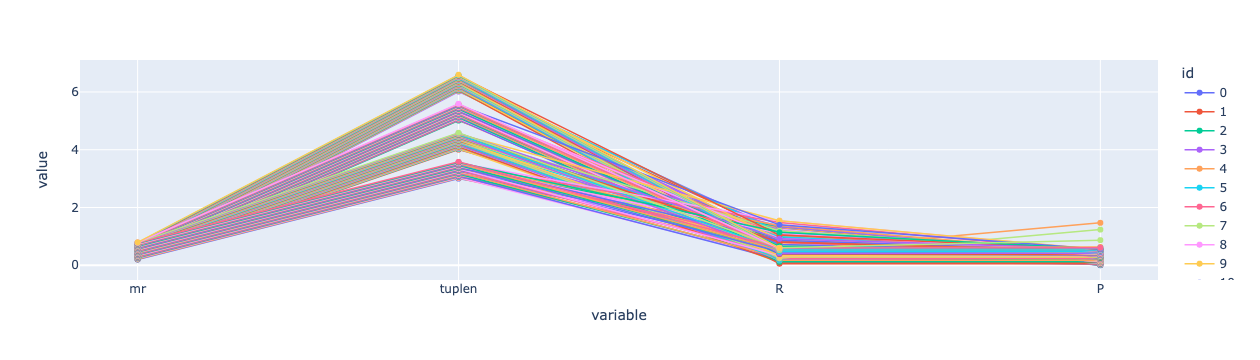

In [78]:
def experiment(conf):
    seqInt = np.random.randint(0,len(alphabet), (conf['N']))
    seqv = alphabet[seqInt]
    seq = ''.join(seqv)
    sketcher = DTS(t=conf['tuplen'], D=conf['m'], D2=conf['m2'], A=len(alphabet)) 
    wmers = [seqInt[i:i+conf['w']] for i in range(0,len(seqInt) - conf['w'] + 1,conf['s'])]
    sketches = sketcher.sketch(wmers)
    lut = build_lookup(sketches, conf['s'])

    paths = generate_paths(seq, conf['path_len'], conf['num_paths'], conf['k'], conf['mr'], alphabet)
    recall, hits, tp, dists = np.zeros((4,conf['num_paths']))
    dists[:] = np.inf

    for i, path in enumerate(tqdm(paths)):
        reference, query, node_path = path
        queryInt = convert(query, alphabet)

        q_wmers = [queryInt[i:i+conf['w']] for i in range(len(queryInt) - conf['w'] + 1)]
        q_sketches = sketcher.sketch(q_wmers)

        # Lookup
        for qi,query_sketch in enumerate(q_sketches):
            if query_sketch not in lut:
                continue
            for node in lut[query_sketch]: # for each node j in the matches
                hits[i] += 1 # count a hit
                ri = (node-node_path[0]) # relative node location to reference head 
                # if abs(ri-qi) <= conf['recall_dist']:
                #     tp[i] += 1
                #     recall[i] = 1
                if ri<=0 or ri>=len(node_path):
                    continue
                d1 = editdistance.eval(reference[:ri], query[:qi])
                d2 = editdistance.eval(reference[ri:], query[qi:])
                d = editdistance.eval(reference, query)
                dists[i] = min(dists[i],d1+d2-d)
                if(  d1+d2 <= d + conf['recall_dist']):
                    tp[i] += 1
                    recall[i] = 1

    conf['P'] = np.mean(tp[hits>0]/hits[hits>0])  # np.sum(tp)/np.sum(hits) 
    conf['R'] = np.mean(recall) 
    conf['dists_bins'] = list(range(10))
    conf['dists_counts'] = np.histogram(dists,bins=conf['dists_bins']+[np.inf])[0]
    return conf 

def show_board(df, cols):  
    def legend(x):
        leg = []
        for i,s in enumerate(x):
            col = cols[i]
            if int(s)==s:
                leg.append(f'{col}:{int(s)}')
            else:
                leg.append(f'{col}:{s:.2f}')
        return ' '.join(leg)

    df2 = df[cols]
    df2['id'] = df2.index
    # df2['id'] = df2.apply(lambda x: legend(x.tolist()), axis=1)
    # df2[cols] = df2[cols] / df2[cols].max()
    for i in range(len(df2)):
        df2.loc[i,cols] += i*5e-3 # add slight y to make them separately visible
    df2 = pd.melt(df2, id_vars='id',value_vars=cols)
    fig = px.line(df2,x='variable',y='value',color='id')
    fig.update_traces(line=dict(width=1.5),mode="markers+lines")
    fig.show()

# results = []
alphabet = np.array(['A','C','G','T'])

for w in [50]:
    config_grid = dict(
        num_paths = 100,
        N = [int(1e5)],
        mr = [0.2],
        path_len = 200,
        recall_dist = 3,
        k=w,
        m=[10,20,30,50,80],
        m2=[2**5,2**6,2**7],
        tuplen = [3,4,5,6],
        w = w,
        s = [3],
    )

    for conf in dict_configs(config_grid): 
        result = experiment(conf)
        results.append(result)
        print(conf)    

df = pd.DataFrame(results)

show_board(df,cols = ['mr','tuplen','R','P']) # 'N','w','s',m,m2

<ipython-input-78-08e4a0f9e3cb>:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



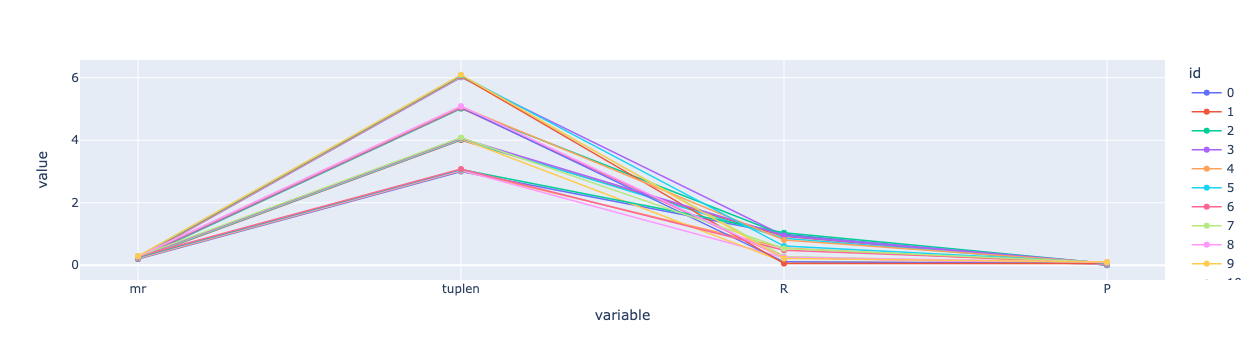

In [79]:
# df.loc[~df.P.isna()]
show_board(df.iloc[:20],cols = ['mr','tuplen','R','P']) # 'N','w','s',m,m2

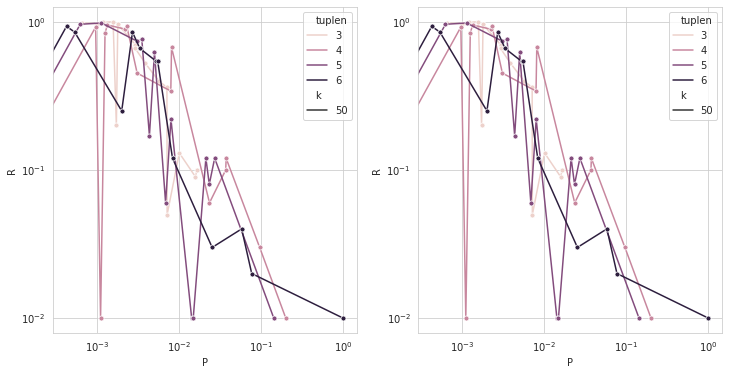

In [74]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results)
Ys = ['P', 'R']
fig,axes = plt.subplots(1,len(Ys),figsize=(len(Ys)*6,6))
for y,ax in zip(Ys,axes):
    sns.set_style("whitegrid")
    fig = sns.lineplot(ax=ax,data=df,y=(df.R),x=(df.P),marker='.',markersize=10,hue='tuplen',style='k')
    fig.set(xscale='log')
    fig.set(yscale='log')
    # ax.set_ylim(0,1)

plt.grid(True)

# Measuring time

In [20]:
times = []
sketcher = DTS(t=conf['tuplen'], D=conf['m'], D2=conf['m2'], A=len(alphabet))    

for N in [1000000, 2000000,5000000, 10000000]:
    seqv = np.random.choice(alphabet, N)
    seq = ''.join(seqv)
    wmers = [np.random.randint(0,4,int(15)) for i in range(int(N/15))]
    start = time.time()
    sketcher.sketch(wmers)
    end = time.time()
    print(f'{N}: {end-start}')
    times.append(end-start)


1000000: 0.7615973949432373
2000000: 1.5311558246612549
5000000: 3.8517634868621826
10000000: 7.619181394577026


# Multi-level sketching

In [ ]:
def sketch_multi(s):
    h = s
    m = conf['w']
    h = [h[i:i+m] for i in range(0,len(h) - m + 1,m)]
    h = np.array(sketcher.sketch(h)) % conf['alpha2']
    h1 = h

    m = conf['m2']
    h = [h[i:i+m] for i in range(0,len(h) - m + 1,m)]
    h = sketcher2.sketch(h)
    h = np.array(h) % conf['alpha3']
    h2 = h

    return h1, h2


w = 10
w2 = 10
alpha = 4


config_grid = dict(
    num_paths = 100,
    N = [200],
    mutation_rate = [0.1],
    path_len = 20*w*w2,
    embed_dim= 20,
    embed_dim2= 2**4,
    recall_distance = 3,
    m = w,
    tuple_length = 2,
    m2 = w2,
    tuple_length2= 4,
    alpha2= 4 ,
    alpha3= 8 ,
)

conf = next( dict_configs(config_grid) )

Len = conf['path_len']
Num = conf['N']
sketcher = DTS(t=conf['tuple_length'], D=conf['embed_dim'], D2=conf['embed_dim2'], A=alpha) 
sketcher2 = DTS(t=conf['tuple_length2'], D=conf['embed_dim'], D2=conf['embed_dim2'], A=conf['alpha2'])   
seqs = np.random.randint(0,alpha,(2,Num,Len))
for i in range(Num):
    I = np.random.permutation(Len)[:np.random.randint(Len)]
    seqs[1,i,I] = seqs[0,i,I] 
seqs = seqs.reshape(2,Num,Len)
Dists = np.zeros((3,Num))
for i in range(Num):
    seq, seq2 = seqs[0,i,:], seqs[1,i,:]
    h, H = sketch_multi(seq)
    h2,H2 = sketch_multi(seq2)
    d1 = editdistance.eval(seq, seq2)
    d2 = editdistance.eval(h, h2)
    d3 = editdistance.eval(H, H2)
    d3 = np.mean(H!=H2)
    Dists[:,i] = (d1,d2,d3)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(Dists[0]/Len,Dists[1],10,alpha=.5)
axes[1].scatter(Dists[0]/Len,Dists[2],10,alpha=.5)